In [1]:

# ------------------------
# 1. SETUP AND IMPORTS
# ------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Visualization settings
plt.style.use('ggplot')
%matplotlib inline

# ------------------------
# 2. DATA LOADING
# ------------------------


try:
    # Load data with timestamp parsing
    df = pd.read_csv(f'../data/raw/data.csv')
    print(f"✅ Successfully loaded data with shape {df.shape}")
except FileNotFoundError:
    print(f"❌ Error: File '../../data/data.csv' not found")
    raise

✅ Successfully loaded data with shape (95662, 16)


In [6]:
# ------------------------
# 3. DATA PROFILING
# ------------------------
print("\n=== DATA PROFILE ===")

# 3.1 Basic Info
print("\n[Data Types & Structure]")
display(df.info())

# 3.2 Summary Statistics
print("\n[Summary Statistics - Numeric Columns]")
display(df.describe(include=[np.number]))

# 3.3 Missing Value Analysis
print("\n[Missing Values Report]")
missing_values = df.isna().sum()
missing_pct = (missing_values / len(df)) * 100
display(missing_values)

high_null_cols = missing_pct[missing_pct > 5]
print("\n[Columns with >5% Missing Values]")
display(high_null_cols)


=== DATA PROFILE ===

[Data Types & Structure]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       

None


[Summary Statistics - Numeric Columns]


,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000



[Missing Values Report]


TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
FraudResult             0
dtype: int64


[Columns with >5% Missing Values]


Series([], dtype: float64)

In [21]:
# ---------------
# DATA CLEANING
# ---------------

data_fields = [
    'TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
    'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory',
    'ChannelId', 'Amount', 'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult'
]

# 1. Keep only relevant columns
df_clean = df[data_fields].copy()

# 2. Remove duplicates
df_clean.drop_duplicates(inplace=True)

# 3. Handle missing values
num_cols = ['Amount', 'Value', 'CountryCode']
cat_cols = ['CurrencyCode', 'ChannelId', 'ProductCategory', 'PricingStrategy', 'FraudResult']

for col in num_cols:
    if col in df_clean.columns:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)

for col in cat_cols:
    if col in df_clean.columns:
        mode_val = df_clean[col].mode()[0]
        df_clean[col].fillna(mode_val, inplace=True)

# 4. Outlier treatment for numerical columns (z-score > 3)
from scipy import stats
for col in num_cols:
    if col in df_clean.columns:
        z = np.abs(stats.zscore(df_clean[col]))
        outliers = z > 3
        median_val = df_clean[col].median()
        df_clean.loc[outliers, col] = median_val

# 5. Reset index after cleaning
df_clean.reset_index(drop=True, inplace=True)

print(f"✅ Cleaned data shape: {df_clean.shape}")
df_clean.head()


✅ Cleaned data shape: (95662, 16)


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


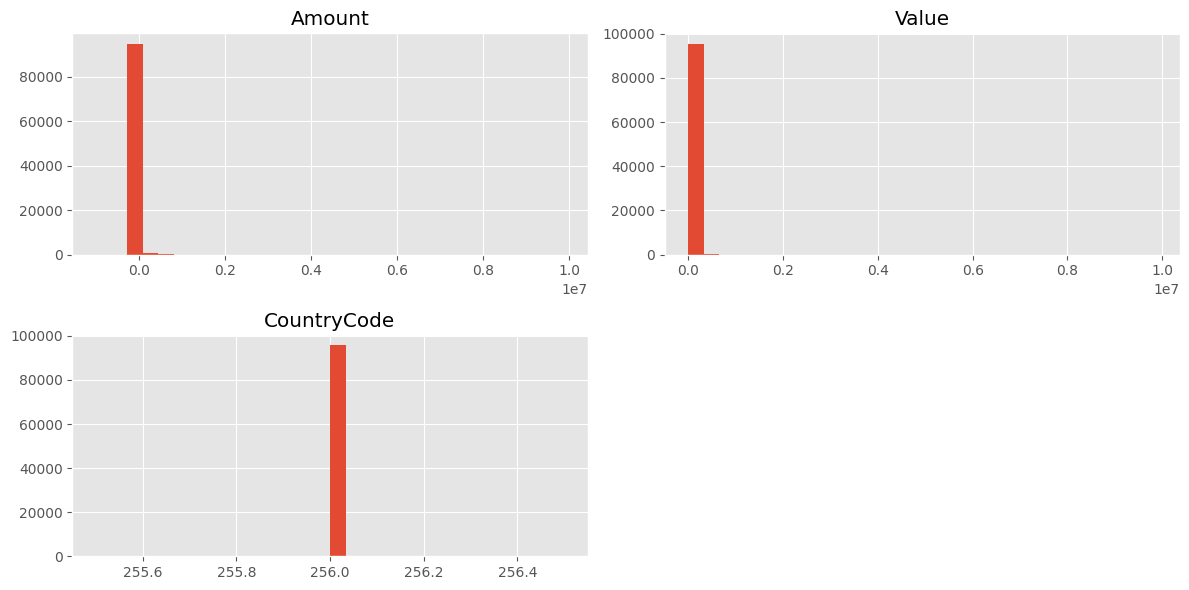

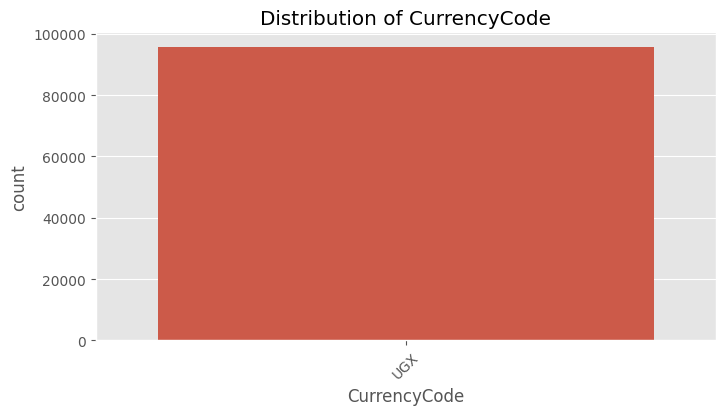

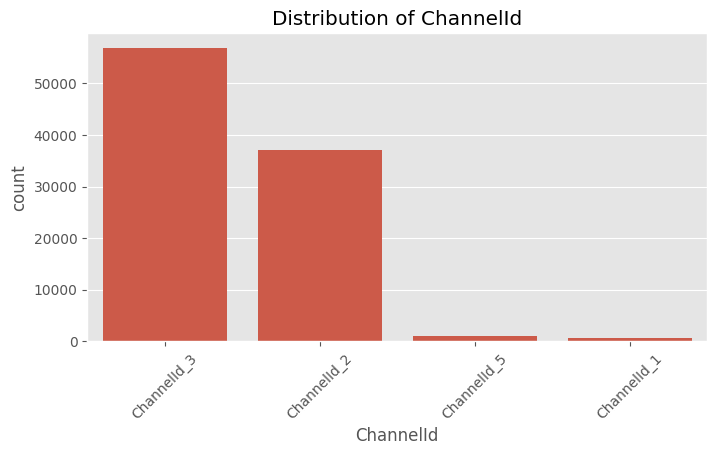

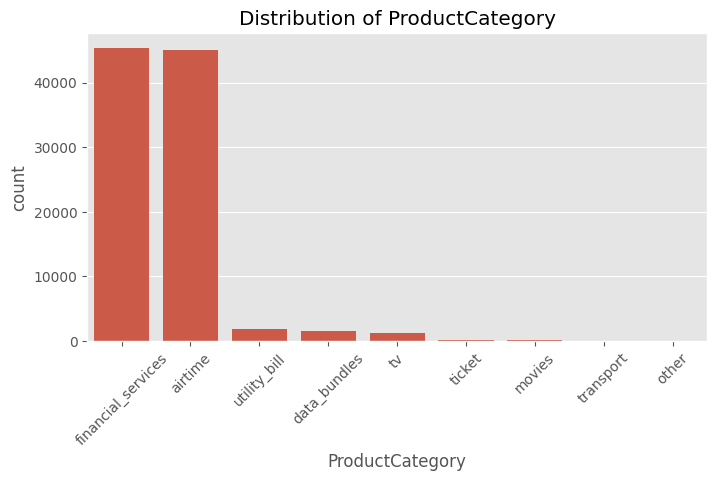

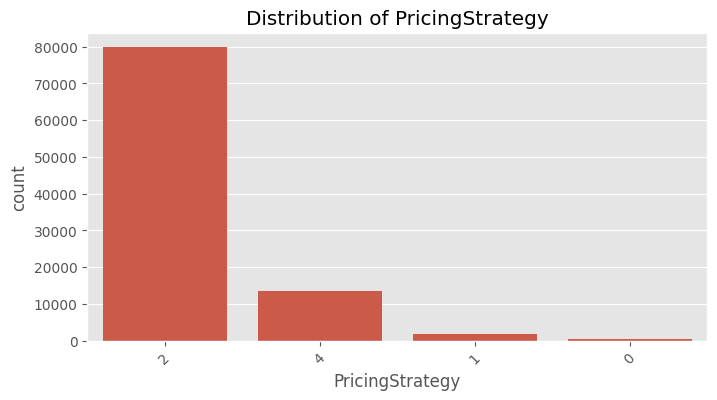

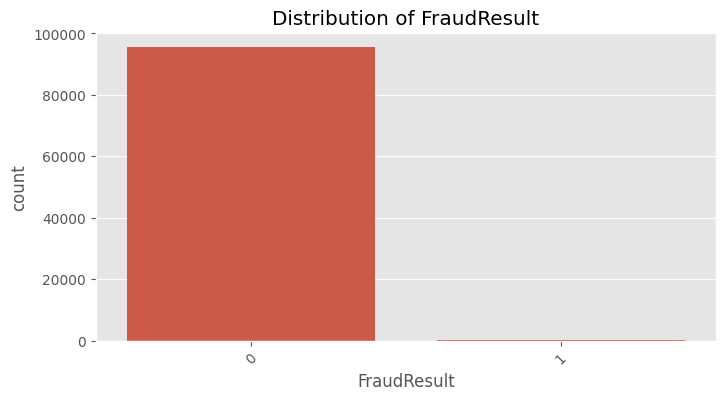

In [19]:
#------------------
# Numerical columns
#------------------

num_cols = ['Amount', 'Value', 'CountryCode']

df[num_cols].hist(figsize=(12, 6), bins=30)
plt.tight_layout()
plt.show()

# Categorical columns
cat_cols = ['CurrencyCode', 'ChannelId', 'ProductCategory', 'PricingStrategy', 'FraudResult']

# Count plots
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

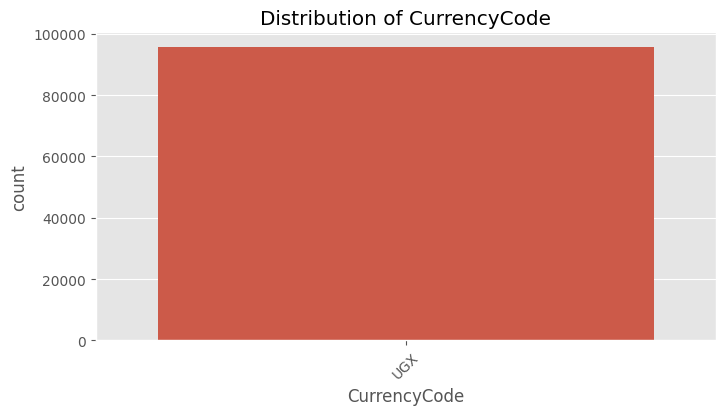

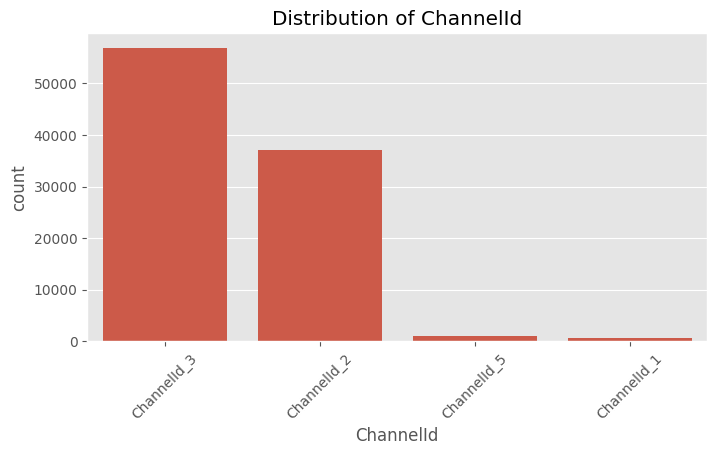

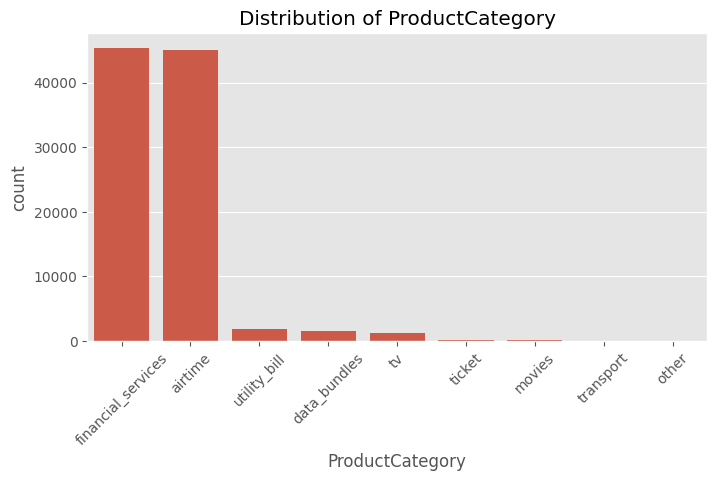

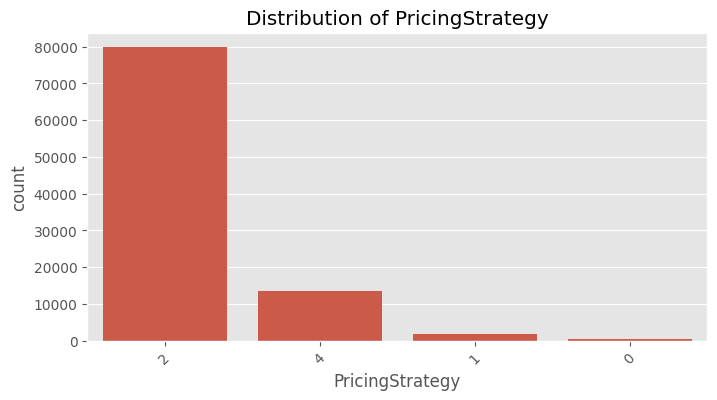

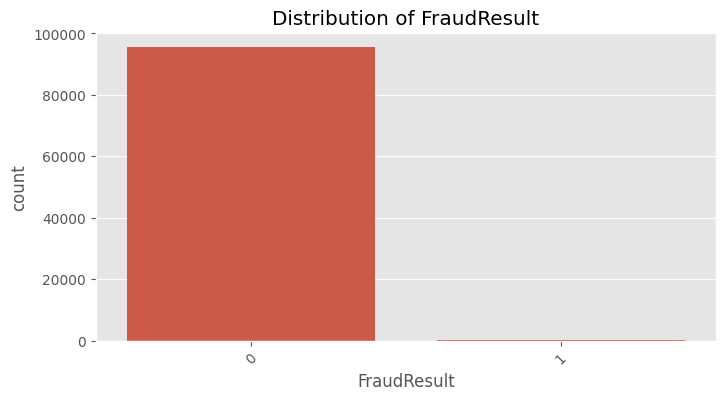

In [ ]:
# ------------------------
# COUNTER PLOT
# ------------------------
cat_cols = ['CurrencyCode', 'ChannelId', 'ProductCategory', 'PricingStrategy', 'FraudResult']
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()


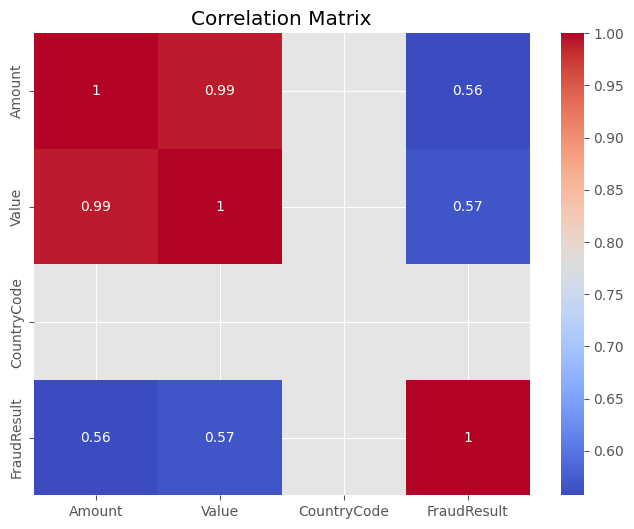

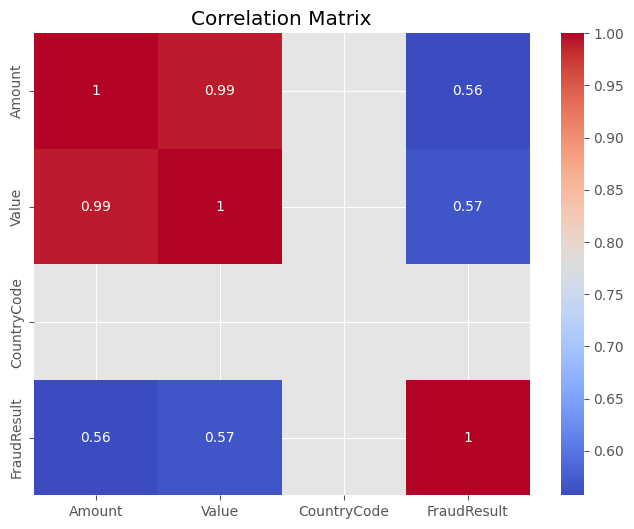

In [ ]:
# ------------------------
# CORRELATION ANALYSIS
# ------------------------

plt.figure(figsize=(8, 6))
sns.heatmap(df[num_cols + ['FraudResult']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# ---------------------------
# IDENTIFYING MISSING VALUES
# ---------------------------
missing_values = df.isna().sum()
missing_pct = (missing_values / len(df)) * 100
display(missing_values)
high_null_cols = missing_pct[missing_pct > 5]
display(high_null_cols)

TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
FraudResult             0
dtype: int64

Series([], dtype: float64)

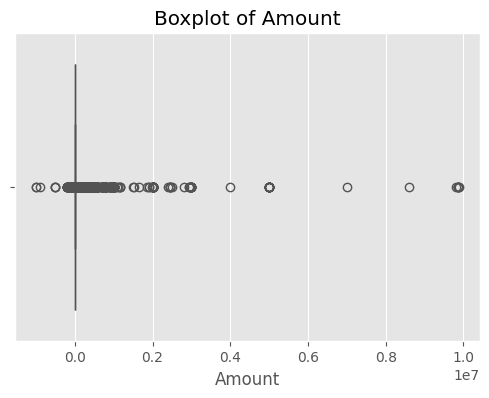

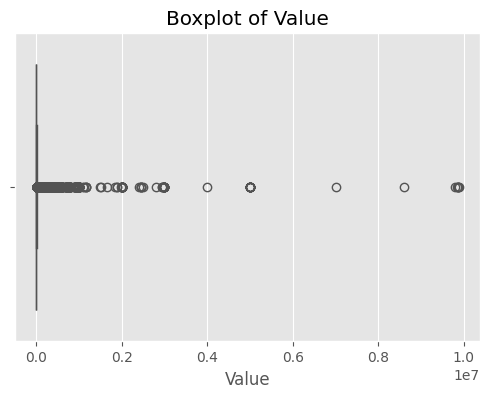

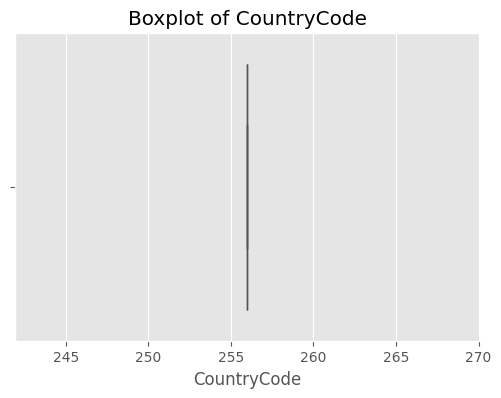

In [ ]:
# ------------------------
# OUTLIER DETECTION
# ------------------------
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()